# Calculate Value Metrics

In [1]:
import pandas as pd
from ipynb.fs.full.c_Stock_visual_QC import read_data_from_sql          # import function from other .ipynb file
pd.options.mode.chained_assignment = None # not to get SettingWithCopyWarning

Connection to SQLite DB successful!
Data has been collected!
Datatype has been updated!
Connection closed!


## To Set Values scroll down...

## Functions to use

In [2]:
def get_avg_share_prices(ticker=str, start=str, period='max', interval='1wk'):
    import yfinance as yf
    # get data from Yahoo Finance
    data = yf.download(
        tickers=ticker,
        start=start,
        period=period,
        interval=interval
        )
    # transform Data Frame
    result = pd.DataFrame()
    result['end'] = data.index
    result['price'] = (data['High'].values + data['Low'].values) / 2

    return result

In [3]:
def match_acounting_with_price(df_acounting, df_price):
    result = pd.merge_asof(df_acounting.sort_values('end'), df_price[['end', 'price']].sort_values('end'), on="end")

    return result

In [4]:
def calculate_pe_ratio(df, form='10-Q'):
    if form == '10-Q' or form == '10-K':
        df = df.loc[df.form == form]
        df.reset_index(drop=True, inplace=True)
        # calculate Earning Per Share (EPS) Trailing Twelve Months (TTM)
        # Quaterly report
        if form == '10-Q':
            eps_ttm_list = []
            for index, value in enumerate(df['eps_dil']):
                if index > 2:
                    eps_ttm_value = value + df['eps_dil'].iloc[index-1] + df['eps_dil'].iloc[index-2] + df['eps_dil'].iloc[index-3]
                elif index == 2:
                    eps_ttm_value = (2 * value) + df['eps_dil'].iloc[index-1] + df['eps_dil'].iloc[index-2]
                elif index == 1:
                    eps_ttm_value = (3 * value) + df['eps_dil'].iloc[index-1]
                elif index == 0:
                    eps_ttm_value = (4 * value)
                eps_ttm_list.append(eps_ttm_value)
            df['eps_ttm'] = pd.Series(eps_ttm_list)
        # Annual report
        if form == '10-K':
            df['eps_ttm'] = df['eps_dil'].copy()
            
        df['pe_ratio'] = df['price'] / df['eps_ttm']
    else:
        print('Not implemented report type.')
        df = None
    
    return df

In [5]:
def calculate_pb_ratio(df):
    # calculate Total Liabilities
    if 'tot_liab' not in df.columns:
        df['tot_liab'] = df['tot_ass'] - df['tot_equity']
    # Calculate Book Value
    df['book_val'] = df['tot_ass'] - df['tot_liab']     # it's the equity value
    ## Calculate Tangible Book Value
    #df['tang_book_val'] = df['book_val'] - (df['intang_ass'] + df['goodwill'])
    # Calculate Price to Book Value per Share
    df['bv_per_share'] = df['book_val'] / df['shares']
    # Calculate Tangible Price to Book Value
    df['pb_ratio'] = df['price'] / df['bv_per_share']

    return df

In [6]:
def calculate_ps_ratio(df, form='10-Q'):
    if form == '10-Q' or form == '10-K':
        df = df.loc[df.form == form]
        df.reset_index(drop=True, inplace=True)
        # calculate Annual Revenue
        # Quaterly report
        if form == '10-Q':
            annual_revenue = []
            for index, value in enumerate(df['rev']):
                if index > 2:
                    rev_ttm_value = value + df['rev'].iloc[index-1] + df['rev'].iloc[index-2] + df['rev'].iloc[index-3]
                elif index == 2:
                    rev_ttm_value = (2 * value) + df['rev'].iloc[index-1] + df['rev'].iloc[index-2]
                elif index == 1:
                    rev_ttm_value = (3 * value) + df['rev'].iloc[index-1]
                elif index == 0:
                    rev_ttm_value = (4 * value)
                annual_revenue.append(rev_ttm_value)
            df['annual_rev'] = pd.Series(annual_revenue)
        # Annual report
        if form == '10-K':
            df['annual_rev'] = df['rev'].copy()

        df['market_cap'] = df['price'] * df['shares']    
        df['ps_ratio'] = df['market_cap'] / df['annual_rev']
    else:
        print('Not implemented report type.')
        df = None
    
    return df

In [7]:
def calculate_roe_roa(df, form='10-Q'):
    if form == '10-Q' or form == '10-K':
        df = df.loc[df.form == form]
        df.reset_index(drop=True, inplace=True)
        # calculate Annual Revenue
        # Quaterly report
        if form == '10-Q':
            annual_net_income = []
            for index, value in enumerate(df['net_inc']):
                if index > 2:
                    net_inc_ttm_value = value + df['net_inc'].iloc[index-1] + df['net_inc'].iloc[index-2] + df['net_inc'].iloc[index-3]
                elif index == 2:
                    net_inc_ttm_value = (2 * value) + df['net_inc'].iloc[index-1] + df['net_inc'].iloc[index-2]
                elif index == 1:
                    net_inc_ttm_value = (3 * value) + df['net_inc'].iloc[index-1]
                elif index == 0:
                    net_inc_ttm_value = (4 * value)
                annual_net_income.append(net_inc_ttm_value)
            df['net_inc_ttm'] = pd.Series(annual_net_income)
        # Annual report
        if form == '10-K':
            df['net_inc_ttm'] = df['net_inc'].copy()
        
        df['roe'] = df['net_inc_ttm'] / df['tot_equity']
        df['roa'] = df['net_inc_ttm'] / df['tot_ass']
    else:
        print('Not implemented report type.')
        df = None
    
    return df

In [8]:
def calculate_current_ratio(df):
    df['current_ratio'] = df['tot_curr_ass'] / df['tot_curr_liab']

    return df

In [9]:
def calculate_depth_to_equity(df):
    df['de_ratio'] = df['tot_liab'] / df['tot_equity']

    return df

In [10]:
# add Ticker to df and ticker suffix to result column
def plot_ratios(df):
    import matplotlib.pyplot as plt
    # result dataframe
    result = pd.DataFrame()
    # add colums which won't be plotted
    for column in ['cik', 'ticker', 'end', 'form', 'price']:
        result[column] = df[column].copy()

    for column in df.columns:
        if column in ['eps_ttm', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'roe', 'roa', 'current_ratio', 'de_ratio']:
            result[column] = df[column].copy()
            try:
                fig, ax1 = plt.subplots(figsize=(15, 6))

                ax2 = ax1.twinx()
                ax1.plot(df.end, df['price'], color='k', label='Stock Price')
                ax2.scatter(df.end, df[column], color='r', label='Ratio values')

                ax1.set_xlabel('Date')
                ax1.set_ylabel('StockPrice (USD)')
                ax2.set_ylabel(column.replace('_', ' ').upper())

                plt.legend()
                plt.show()
            except:
                continue

    return result

## 1. Price-to-Earnings Ratio

- The price-to-earnings ratio is the proportionate value of a share’s market price and earnings. It shows the number of times the earnings need to be invested in a stock.
- Calculation: PE Ratio = Price Per Share/ Earnings Per Share.
- The trailing price-to-earnings ratio is based on past earnings, while the forward price-to-earnings ratio depends on the forecast of future earnings.
- The analysts correlate a company’s PE multiple with the PE multiples of competition within the industry. This way, the appropriate valuation of a share is ascertained.

I'll calculate trailing PE (last 12 months), and NOT the forward PE (next 12 months).

In [11]:
# input parameters
db_path = '../database/statements.db'
form = '10-Q'
# loader function from 'c' notebook
data = read_data_from_sql(
    db_path=db_path,
    tickers=['IFF'],
    statements=['income_statement', 'balance_sheet']    
)
# filter DataFrame
data = data.loc[data.form == form]
data.head()

Connection to SQLite DB successful!
Data has been collected!
Datatype has been updated!
Connection closed!


,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,intang_ass,other_ass,tot_ass,short_debt,acc_pay,other_curr_liab,tot_curr_liab,tot_long_debt,other_liab,tot_equity
0,0000051253,IFF,2018-06-30,10-Q,9.200160e+08,521299000.0,157407000.0,0.0,154509000.0,20655000.0,...,3.914260e+08,157017000.0,4.673442e+09,6500000.0,315656000.0,263448000.0,6.993700e+08,1.717189e+09,238635000.0,1.749855e+09
1,0000051253,IFF,2018-09-30,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,3.855750e+08,167978000.0,9.615542e+09,45985000.0,312236000.0,257364000.0,7.584560e+08,4.331242e+09,235332000.0,4.031814e+09
2,0000051253,IFF,2018-12-31,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,3.039322e+09,288673000.0,1.288940e+10,48642000.0,471382000.0,530508000.0,1.128311e+09,4.504417e+09,248436000.0,6.032951e+09
4,0000051253,IFF,2019-03-31,10-Q,1.297402e+09,766143000.0,213182000.0,0.0,163870000.0,7278000.0,...,2.974177e+09,583389000.0,1.321142e+10,84003000.0,476413000.0,414626000.0,1.144134e+09,4.421430e+09,492029000.0,6.143211e+09
5,0000051253,IFF,2019-06-30,10-Q,1.291568e+09,745329000.0,210100000.0,0.0,199937000.0,2137000.0,...,2.944667e+09,590767000.0,1.334808e+10,84231000.0,463555000.0,429939000.0,1.149533e+09,4.428675e+09,514802000.0,6.199379e+09


In [12]:
prices = get_avg_share_prices(
    ticker='IFF',
    start='2010-10-01'
)
prices.head()

[*********************100%%**********************]  1 of 1 completed


,end,price
0,2010-09-27,48.920000
1,2010-10-04,49.110001
2,2010-10-11,49.525000
3,2010-10-18,49.510000
4,2010-10-25,49.799999


In [13]:
merged = match_acounting_with_price(data, prices)
merged.tail()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,other_ass,tot_ass,short_debt,acc_pay,other_curr_liab,tot_curr_liab,tot_long_debt,other_liab,tot_equity,price
16,0000051253,IFF,2022-06-30,10-Q,3.307000e+09,2.171000e+09,456000000.0,120000000.0,2.130000e+08,-6000000.0,...,726000000.0,3.930400e+10,9.570000e+08,1.576000e+09,8.660000e+08,4.720000e+09,1.036300e+10,462000000.0,2.026000e+10,118.465000
17,0000051253,IFF,2022-09-30,10-Q,3.063000e+09,2.062000e+09,413000000.0,0.0,-1.985000e+09,33000000.0,...,663000000.0,3.453700e+10,3.080000e+08,1.527000e+09,1.128000e+09,3.626000e+09,1.026000e+10,472000000.0,1.688700e+10,94.024998
18,0000051253,IFF,2022-12-31,10-Q,3.063000e+09,2.062000e+09,413000000.0,0.0,-1.985000e+09,33000000.0,...,689000000.0,3.550400e+10,4.100000e+08,1.418000e+09,1.028000e+09,3.728000e+09,1.037300e+10,491000000.0,1.765500e+10,104.084999
19,0000051253,IFF,2023-03-31,10-Q,3.027000e+09,2.063000e+09,454000000.0,0.0,1.310000e+08,-6000000.0,...,744000000.0,3.547000e+10,1.483000e+09,1.197000e+09,9.650000e+08,4.874000e+09,9.220000e+09,494000000.0,1.775800e+10,88.580002
20,0000051253,IFF,2023-06-30,10-Q,2.929000e+09,1.996000e+09,445000000.0,0.0,1.450000e+08,21000000.0,...,754000000.0,3.445900e+10,1.203000e+09,1.227000e+09,9.190000e+08,3.932000e+09,9.208000e+09,504000000.0,1.762300e+10,77.480000


In [14]:
merged = calculate_pe_ratio(merged, form=form)
merged.head()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,short_debt,acc_pay,other_curr_liab,tot_curr_liab,tot_long_debt,other_liab,tot_equity,price,eps_ttm,pe_ratio
0,0000051253,IFF,2018-06-30,10-Q,9.200160e+08,521299000.0,157407000.0,0.0,154509000.0,20655000.0,...,6500000.0,315656000.0,263448000.0,6.993700e+08,1.717189e+09,238635000.0,1.749855e+09,123.585003,5.00,24.717001
1,0000051253,IFF,2018-09-30,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,45985000.0,312236000.0,257364000.0,7.584560e+08,4.331242e+09,235332000.0,4.031814e+09,138.244995,4.76,29.043066
2,0000051253,IFF,2018-12-31,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,48642000.0,471382000.0,530508000.0,1.128311e+09,4.504417e+09,248436000.0,6.032951e+09,133.884995,4.76,28.127100
3,0000051253,IFF,2019-03-31,10-Q,1.297402e+09,766143000.0,213182000.0,0.0,163870000.0,7278000.0,...,84003000.0,476413000.0,414626000.0,1.144134e+09,4.421430e+09,492029000.0,6.143211e+09,126.345001,4.55,27.768132
4,0000051253,IFF,2019-06-30,10-Q,1.291568e+09,745329000.0,210100000.0,0.0,199937000.0,2137000.0,...,84231000.0,463555000.0,429939000.0,1.149533e+09,4.428675e+09,514802000.0,6.199379e+09,145.055000,4.50,32.234445


## 2. Price-to-Book Ratio & Book Value per Shares

- Book Value = Total Assets - Total Liabilitites
- Tangible Book Value = Total Assets - (Intangible Assets + Goodwill) - Total Liabilities
- Book Value per Share = Book Value/ share number
- Price to Book Ratio (P/B) = Share price / Book Value per Share

#### Huge amount of Intangible Asset has not been corrected!


In [15]:
merged = calculate_pb_ratio(merged)
merged.tail()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,tot_long_debt,other_liab,tot_equity,price,eps_ttm,pe_ratio,tot_liab,book_val,bv_per_share,pb_ratio
16,0000051253,IFF,2022-06-30,10-Q,3.307000e+09,2.171000e+09,456000000.0,120000000.0,2.130000e+08,-6000000.0,...,1.036300e+10,462000000.0,2.026000e+10,118.465000,2.91,40.709622,1.904400e+10,2.026000e+10,79.450980,1.491045
17,0000051253,IFF,2022-09-30,10-Q,3.063000e+09,2.062000e+09,413000000.0,0.0,-1.985000e+09,33000000.0,...,1.026000e+10,472000000.0,1.688700e+10,94.024998,-6.45,-14.577519,1.765000e+10,1.688700e+10,66.223529,1.419813
18,0000051253,IFF,2022-12-31,10-Q,3.063000e+09,2.062000e+09,413000000.0,0.0,-1.985000e+09,33000000.0,...,1.037300e+10,491000000.0,1.765500e+10,104.084999,-15.81,-6.583491,1.784900e+10,1.765500e+10,69.235294,1.503352
19,0000051253,IFF,2023-03-31,10-Q,3.027000e+09,2.063000e+09,454000000.0,0.0,1.310000e+08,-6000000.0,...,9.220000e+09,494000000.0,1.775800e+10,88.580002,-16.81,-5.269483,1.771200e+10,1.775800e+10,69.639216,1.271984
20,0000051253,IFF,2023-06-30,10-Q,2.929000e+09,1.996000e+09,445000000.0,0.0,1.450000e+08,21000000.0,...,9.208000e+09,504000000.0,1.762300e+10,77.480000,-17.13,-4.523059,1.683600e+10,1.762300e+10,69.109804,1.121114


## 3. Price-to-Sales Ratio & Market Capitalization

- Price to Sales Ratio (P/S) = Market Capitalization / Annual Revenue

A low price-to-sales ratio relative to industry peers could mean that the shares of the company are currently undervalued. The standard acceptable range of the P/S ratio varies across industries. Hence, benchmarking the ratio must be done among similar, comparable companies. Alternatively, a ratio in excess of its peer group could indicate the target company is overvalued. The major downside of the price-to-sales ratio that tends to reduce its reliability is that the P/S ratio does NOT factor in the profitability of companies. While the main advantage of using the P/S ratio is that it can be used to value companies that are yet to be profitable at the operating income (EBIT), EBITDA, or net income line, this fact is also the main drawback. Since the price-to-sales ratio neglects the current or future earnings of companies, the metric can be misleading for unprofitable companies.

In [16]:
merged = calculate_ps_ratio(merged, form=form)
merged.tail()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,price,eps_ttm,pe_ratio,tot_liab,book_val,bv_per_share,pb_ratio,annual_rev,market_cap,ps_ratio
16,0000051253,IFF,2022-06-30,10-Q,3.307000e+09,2.171000e+09,456000000.0,120000000.0,2.130000e+08,-6000000.0,...,118.465000,2.91,40.709622,1.904400e+10,2.026000e+10,79.450980,1.491045,1.267500e+10,3.020858e+10,2.383320
17,0000051253,IFF,2022-09-30,10-Q,3.063000e+09,2.062000e+09,413000000.0,0.0,-1.985000e+09,33000000.0,...,94.024998,-6.45,-14.577519,1.765000e+10,1.688700e+10,66.223529,1.419813,1.266700e+10,2.397637e+10,1.892822
18,0000051253,IFF,2022-12-31,10-Q,3.063000e+09,2.062000e+09,413000000.0,0.0,-1.985000e+09,33000000.0,...,104.084999,-15.81,-6.583491,1.784900e+10,1.765500e+10,69.235294,1.503352,1.265900e+10,2.654167e+10,2.096664
19,0000051253,IFF,2023-03-31,10-Q,3.027000e+09,2.063000e+09,454000000.0,0.0,1.310000e+08,-6000000.0,...,88.580002,-16.81,-5.269483,1.771200e+10,1.775800e+10,69.639216,1.271984,1.246000e+10,2.258790e+10,1.812833
20,0000051253,IFF,2023-06-30,10-Q,2.929000e+09,1.996000e+09,445000000.0,0.0,1.450000e+08,21000000.0,...,77.480000,-17.13,-4.523059,1.683600e+10,1.762300e+10,69.109804,1.121114,1.208200e+10,1.975740e+10,1.635276


## 4. Return on Equity (ROE) & Return on Assets (ROA)

- ROE = Net Income / shareholders' equity
- ROE is a gauge of a corporation's profitability and how efficiently it generates those profits.
- The higher the ROE, the better a company is at converting its equity financing into profits.
- ROEs will vary based on the industry or sector in which the company operates.

- Return on assets is a metric that indicates a company's profitability in relation to its total assets.
- ROA can be used by management, analysts, and investors to determine whether a company uses its assets efficiently to generate a profit.
- ROA = Net Income / total assets
- It's always best to compare the ROA of companies within the same industry because they'll share the same asset base.
- ROA factors in a company's debt while return on equity does not.

In [17]:
merged = calculate_roe_roa(merged, form=form)
merged.head()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,tot_liab,book_val,bv_per_share,pb_ratio,annual_rev,market_cap,ps_ratio,net_inc_ttm,roe,roa
0,0000051253,IFF,2018-06-30,10-Q,9.200160e+08,521299000.0,157407000.0,0.0,154509000.0,20655000.0,...,2.923587e+09,1.749855e+09,22.065433,5.600842,3.680064e+09,9.800661e+09,2.663177,398740000.0,0.227870,0.085320
1,0000051253,IFF,2018-09-30,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,5.583728e+09,4.031814e+09,49.381043,2.799556,3.642660e+09,1.128729e+10,3.098639,386833000.0,0.095945,0.040230
2,0000051253,IFF,2018-12-31,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,6.856444e+09,6.032951e+09,73.890663,1.811934,3.642660e+09,1.093131e+10,3.000914,386833000.0,0.064120,0.030012
3,0000051253,IFF,2019-03-31,10-Q,1.297402e+09,766143000.0,213182000.0,0.0,163870000.0,7278000.0,...,7.068209e+09,6.143211e+09,54.178192,2.332027,4.032514e+09,1.432613e+10,3.552656,402331000.0,0.065492,0.030453
4,0000051253,IFF,2019-06-30,10-Q,1.291568e+09,745329000.0,210100000.0,0.0,199937000.0,2137000.0,...,7.148703e+09,6.199379e+09,54.923976,2.641014,4.404066e+09,1.637265e+10,3.717621,441515000.0,0.071219,0.033077


## 5. Current Ratio

- The current ratio compares all of a company’s current assets to its current liabilities.
- These are usually defined as assets that are cash or will be turned into cash in a year or less and liabilities that will be paid in a year or less.
- The current ratio helps investors understand more about a company’s ability to cover its short-term debt with its current assets and make apples-to-apples comparisons with its competitors and peers.
- One weakness of the current ratio is its difficulty of comparing the measure across industry groups.
- Others include the overgeneralization of the specific asset and liability balances, and the lack of trending information.

In [18]:
merged = calculate_current_ratio(merged)
merged.head()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,book_val,bv_per_share,pb_ratio,annual_rev,market_cap,ps_ratio,net_inc_ttm,roe,roa,current_ratio
0,0000051253,IFF,2018-06-30,10-Q,9.200160e+08,521299000.0,157407000.0,0.0,154509000.0,20655000.0,...,1.749855e+09,22.065433,5.600842,3.680064e+09,9.800661e+09,2.663177,398740000.0,0.227870,0.085320,2.897722
1,0000051253,IFF,2018-09-30,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,4.031814e+09,49.381043,2.799556,3.642660e+09,1.128729e+10,3.098639,386833000.0,0.095945,0.040230,9.159169
2,0000051253,IFF,2018-12-31,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,6.032951e+09,73.890663,1.811934,3.642660e+09,1.093131e+10,3.000914,386833000.0,0.064120,0.030012,2.607313
3,0000051253,IFF,2019-03-31,10-Q,1.297402e+09,766143000.0,213182000.0,0.0,163870000.0,7278000.0,...,6.143211e+09,54.178192,2.332027,4.032514e+09,1.432613e+10,3.552656,402331000.0,0.065492,0.030453,2.557240
4,0000051253,IFF,2019-06-30,10-Q,1.291568e+09,745329000.0,210100000.0,0.0,199937000.0,2137000.0,...,6.199379e+09,54.923976,2.641014,4.404066e+09,1.637265e+10,3.717621,441515000.0,0.071219,0.033077,2.601079


## 6. Debt to Equity (D/E)

- Debt-to-equity (D/E) ratio compares a company’s total liabilities with its shareholder equity and can be used to assess the extent of its reliance on debt.
- D/E ratios vary by industry and are best used to compare direct competitors or to measure change in the company’s reliance on debt over time.
- Among similar companies, a higher D/E ratio suggests more risk, while a particularly low one may indicate that a business is not taking advantage of debt financing to expand.
- Investors will often modify the D/E ratio to consider only long-term debt because it carries more risk than short-term obligations.

In [19]:
merged = calculate_depth_to_equity(merged)
merged.head()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,bv_per_share,pb_ratio,annual_rev,market_cap,ps_ratio,net_inc_ttm,roe,roa,current_ratio,de_ratio
0,0000051253,IFF,2018-06-30,10-Q,9.200160e+08,521299000.0,157407000.0,0.0,154509000.0,20655000.0,...,22.065433,5.600842,3.680064e+09,9.800661e+09,2.663177,398740000.0,0.227870,0.085320,2.897722,1.670760
1,0000051253,IFF,2018-09-30,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,49.381043,2.799556,3.642660e+09,1.128729e+10,3.098639,386833000.0,0.095945,0.040230,9.159169,1.384917
2,0000051253,IFF,2018-12-31,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,73.890663,1.811934,3.642660e+09,1.093131e+10,3.000914,386833000.0,0.064120,0.030012,2.607313,1.136499
3,0000051253,IFF,2019-03-31,10-Q,1.297402e+09,766143000.0,213182000.0,0.0,163870000.0,7278000.0,...,54.178192,2.332027,4.032514e+09,1.432613e+10,3.552656,402331000.0,0.065492,0.030453,2.557240,1.150572
4,0000051253,IFF,2019-06-30,10-Q,1.291568e+09,745329000.0,210100000.0,0.0,199937000.0,2137000.0,...,54.923976,2.641014,4.404066e+09,1.637265e+10,3.717621,441515000.0,0.071219,0.033077,2.601079,1.153132


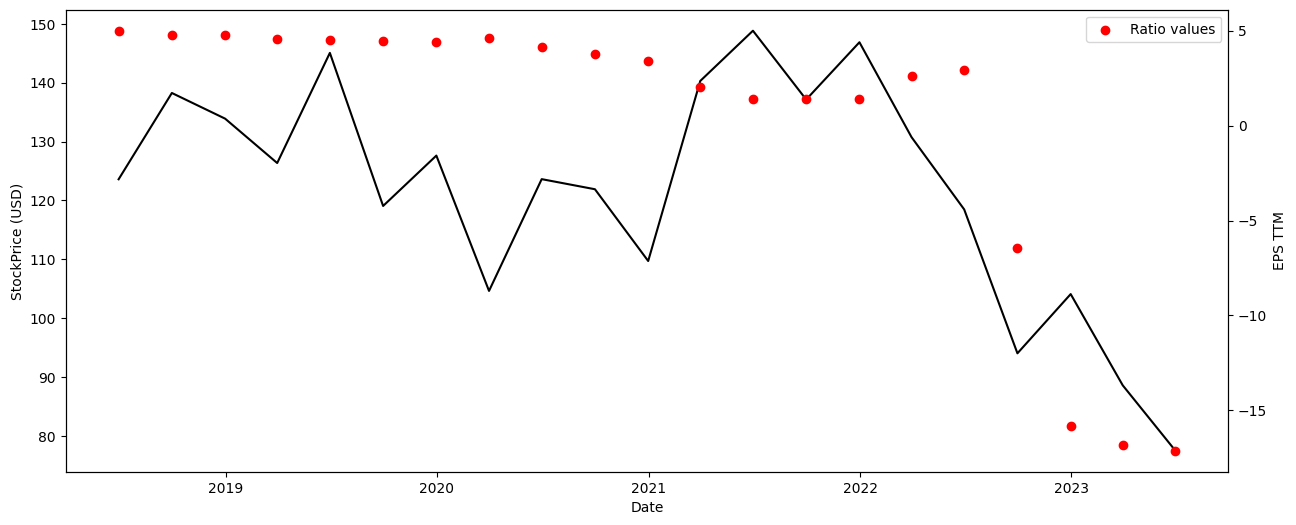

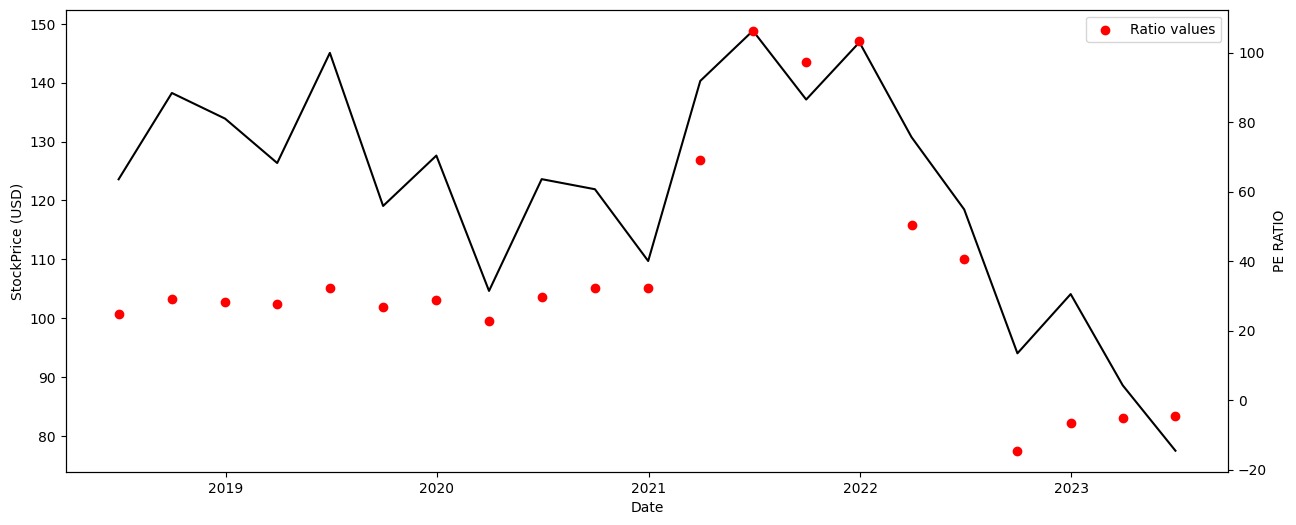

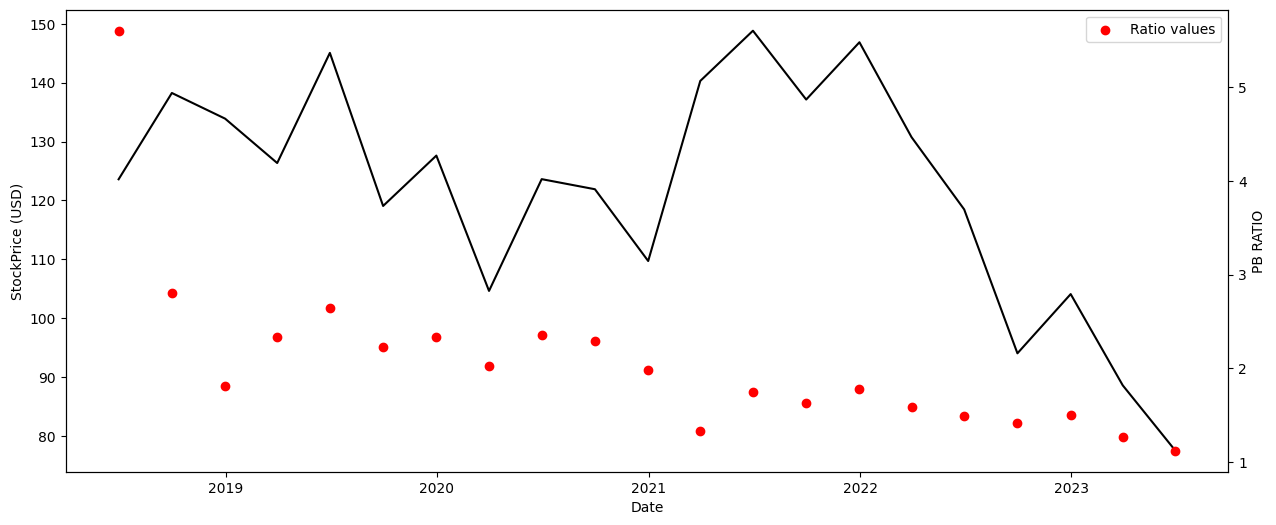

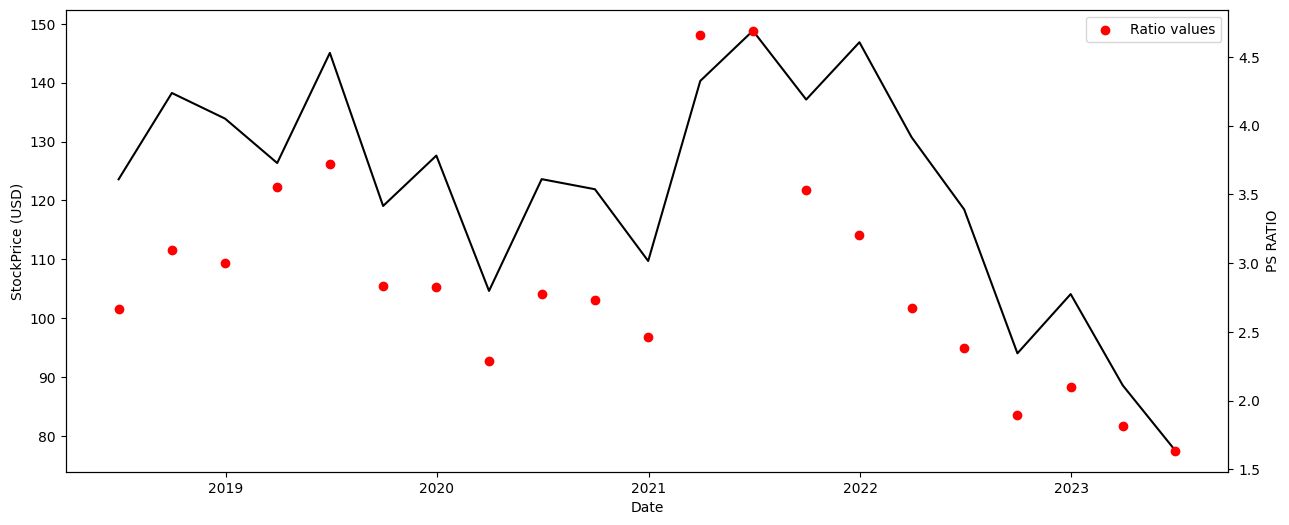

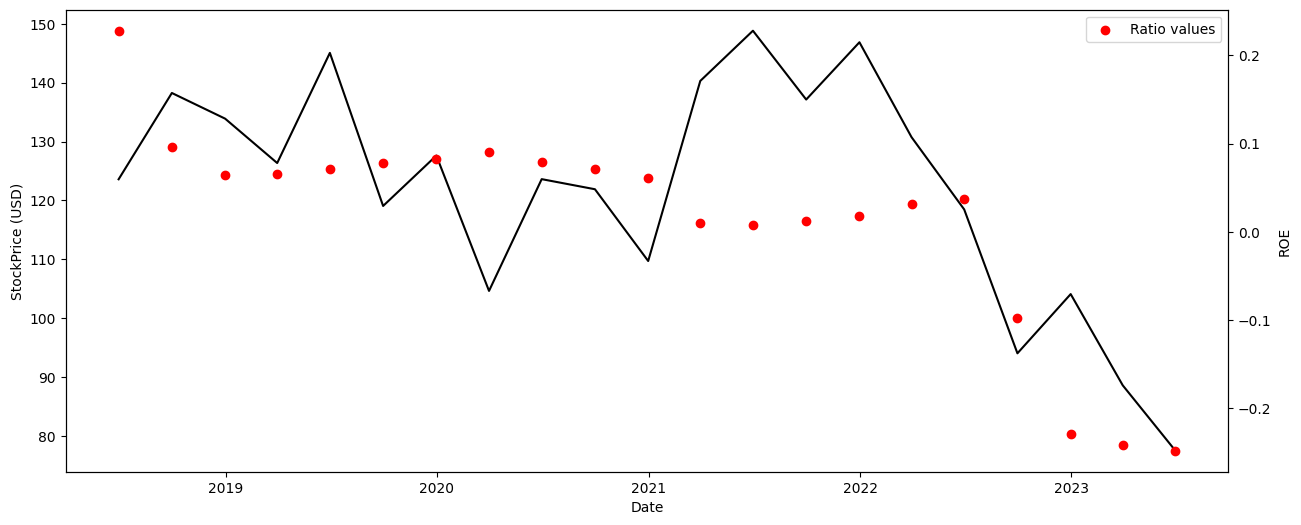

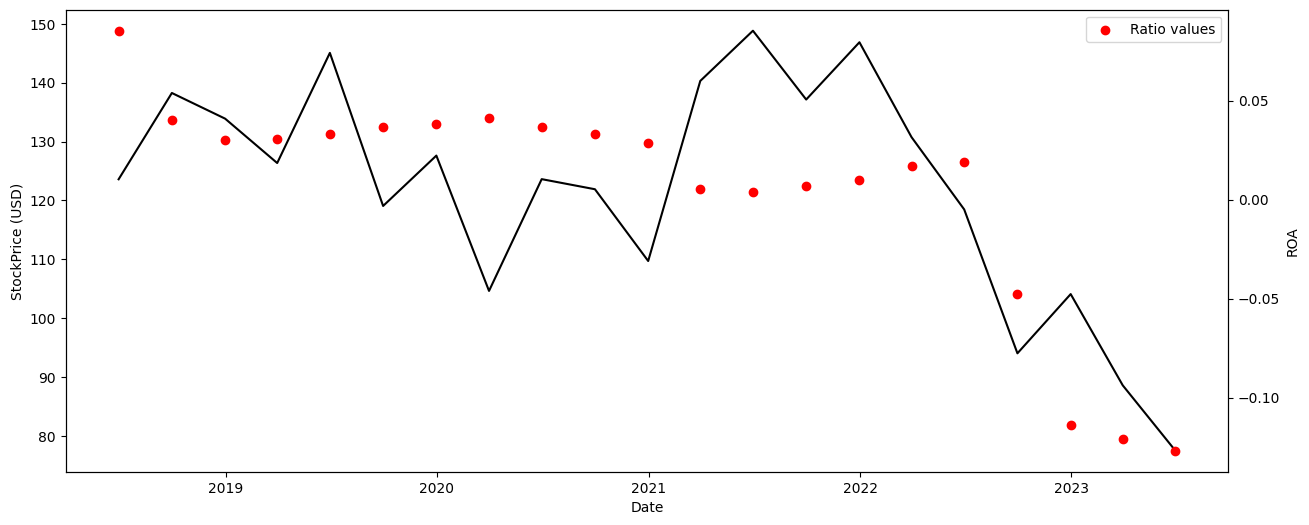

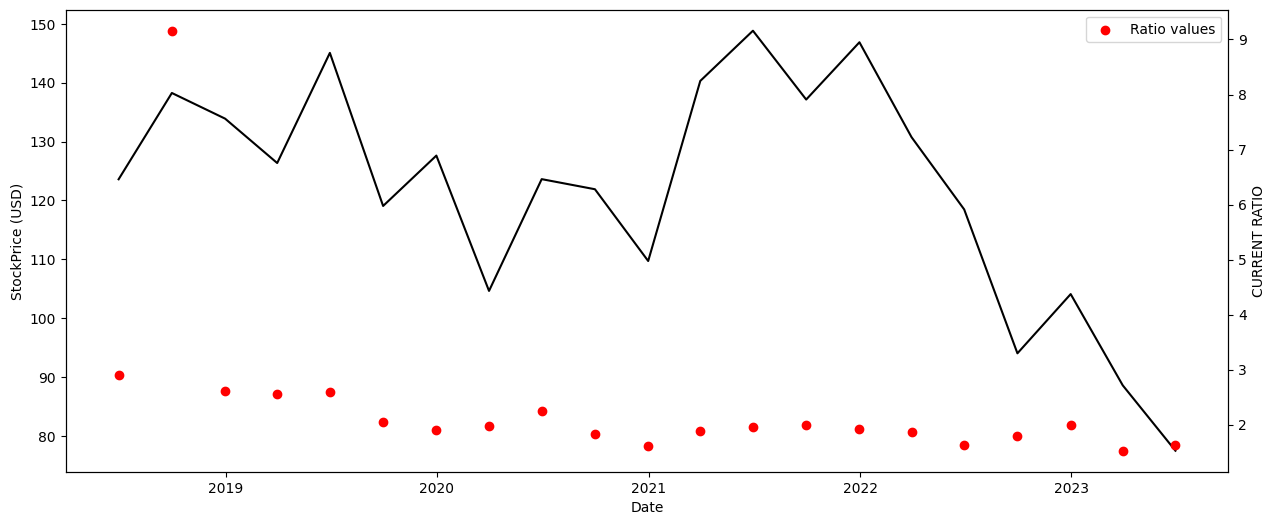

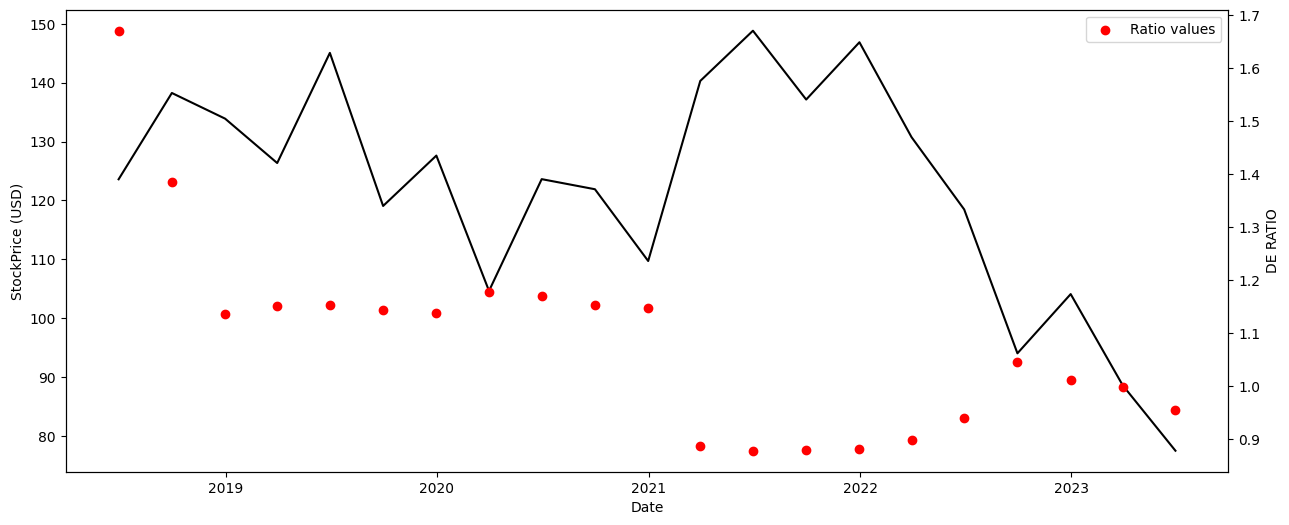

,cik,ticker,end,form,price,eps_ttm,pe_ratio,pb_ratio,ps_ratio,roe,roa,current_ratio,de_ratio
0,0000051253,IFF,2018-06-30,10-Q,123.585003,5.00,24.717001,5.600842,2.663177,0.227870,0.085320,2.897722,1.670760
1,0000051253,IFF,2018-09-30,10-Q,138.244995,4.76,29.043066,2.799556,3.098639,0.095945,0.040230,9.159169,1.384917
2,0000051253,IFF,2018-12-31,10-Q,133.884995,4.76,28.127100,1.811934,3.000914,0.064120,0.030012,2.607313,1.136499
3,0000051253,IFF,2019-03-31,10-Q,126.345001,4.55,27.768132,2.332027,3.552656,0.065492,0.030453,2.557240,1.150572
4,0000051253,IFF,2019-06-30,10-Q,145.055000,4.50,32.234445,2.641014,3.717621,0.071219,0.033077,2.601079,1.153132


In [20]:
result = plot_ratios(merged)
result.head()